<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2024/blob/main/class/Class_Wine_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, Abilene Christian University, PHYS 453**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Common utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay

# Classifiers
from sklearn.neighbors import KNeighborsClassifier

# Class Challenge - Wine KNN

Every time we learn something new we should try it out!

Load the wine data using ```datasets.load_wine``` and train a KNN classifier.

1) Set ```random_state=0``` in the test/train split and tune the classifier.  
1.  First find a clear example of overfitting
1.  Same with underfitting
1.  What does changing the weights option do?
1.  What are the optimal paramters?  What is the best score?

2) Remove the random_state option and investigate how much your answer changes

# Load Data


In [2]:
data_bunch = datasets.load_wine()
data_bunch.keys()
X = data_bunch.data
y = data_bunch.target

target_names = data_bunch.target_names
feature_names = data_bunch.feature_names
print('Targets:\t',target_names)
print('Feature:\t',feature_names)
print('Data shape:\t',X.shape)

Targets:	 ['class_0' 'class_1' 'class_2']
Feature:	 ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Data shape:	 (178, 13)


# Recipe Setup
Following Tutorial 8, here's a recipe for KNN to use.  I'll try to put all of the useful things together in one place

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0) # stratify ensures an equal ratio of each target
print('Train\t',X_train.shape)
print('Test\t',X_test.shape)

Train	 (133, 13)
Test	 (45, 13)


In [4]:
# These functions visualize results from a parameter grid search.

def make_grid_plot_labels(grid_clf):
  # Turns a parameter dictionary entry into a single string and returns the whole list
  res = grid_clf.cv_results_
  NUM_KEYS = len(res['params'][0].values())
  labels = []
  for item in res['params']:
    labels.append("_".join( [str(val) for val in item.values()]))
  return labels

def make_grid_plot(grid_clf):
  # Displays the scores for every set of parameters
  res = grid_clf.cv_results_
  plt.figure(figsize=(8,4))
  plt.axvline(grid_clf.best_index_, color='black', lw=2) # draw black line behind best params

  NUM_KEYS = len(res['params'])
  x = np.arange(NUM_KEYS)
  plt.plot(res['mean_test_score'],'-o', label='Val')
  plt.fill_between(x,res['mean_test_score']+res['std_test_score'], res['mean_test_score']-res['std_test_score'], alpha=0.2)
  #plt.errorbar(x, res['mean_test_score'],yerr=res['std_test_score'],xerr=0,fmt='-o', capsize=2, label='Val')

  plt.plot(res['mean_train_score'],'-s', label='Train')
  plt.fill_between(x,res['mean_train_score']+res['std_train_score'], res['mean_train_score']-res['std_train_score'], alpha=0.2)
  #plt.errorbar(x, res['mean_train_score'],yerr=res['std_train_score'],xerr=0,fmt='-s', capsize=2,label='Train')
  plt.title('Grid CV Results')
  plt.ylabel('Mean Test Score')

  labels = make_grid_plot_labels(grid_clf)
  plt.xticks(ticks = x, labels=labels, rotation=90)
  plt.legend()
  plt.grid()
  plt.show()

In [5]:
def plot_2par_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2,show_train=1):
  """Plot GridCV results for two parameter searches"""
  # from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv with a fixed bug
  val_scores = np.array(cv_results['mean_test_score']).reshape(len(grid_param_1),len(grid_param_2))
  train_scores = np.array(cv_results['mean_train_score']).reshape(len(grid_param_1),len(grid_param_2))
  val_errs = np.array(cv_results['std_test_score']).reshape(len(grid_param_1),len(grid_param_2))
  train_errs = np.array(cv_results['std_train_score']).reshape(len(grid_param_1),len(grid_param_2))
  _, ax = plt.subplots(1,1,figsize=(10,4))
  #cmap = plt.get_cmap("tab10")
  cmap = plt.get_cmap("Dark2") # making this different so we don't confuse train/val

  # show best
  best_index = cv_results['mean_test_score'].argmax()
  best_x = cv_results['params'][best_index]['clf__'+name_param_1]
  ax.axvline(best_x,color='k')

  # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
  for idx, val in enumerate(grid_param_2): # plot val
    #ax.errorbar(grid_param_1, val_scores[:,idx], yerr=val_errs[:,idx], xerr=0, fmt='-o', capsize=4, color=cmap(idx), label=f"Val:   {name_param_2}={str(val)}") # plot with error bars
    ax.errorbar(grid_param_1, val_scores[:,idx], yerr=0, xerr=0, fmt='-o', capsize=4, color=cmap(idx), label=f"Val:   {name_param_2}={str(val)}")  # plot with no error bars
    ax.fill_between(grid_param_1, val_scores[:,idx]+val_errs[:,idx],val_scores[:,idx]-val_errs[:,idx],alpha=0.2, color=cmap(idx)) # plot error region

    if show_train:  # plot train
      ax.errorbar(grid_param_1, train_scores[:,idx],yerr=train_errs[:,idx],xerr=0,fmt=':.', capsize=4,color=cmap(idx), label=f"Train: {name_param_2}={str(val)}") # plot with error bars
      #ax.fill_between(grid_param_1, train_scores[:,idx]+train_errs[:,idx],train_scores[:,idx]-train_errs[:,idx],color=cmap(idx),alpha=0.2) # plot error region

  ax.set_title("Grid Search Scores")
  ax.set_xlabel(name_param_1)
  ax.set_ylabel('CV Average Score')
  ax.legend(loc='upper right')
  ax.grid('on')

# Recipe


**References**
* User Guide: http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors
* API: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


**Parameters to know**
* ```n_neighbors```: also known as *k*, the number of neighbors. Default is 5
* ```weights```={‘uniform’, ‘distance’}: changes sensitivity to outliers, distance can work better but it is annoying that the validation score is always 1

**Training Notes**
* k=1 overfits while large values of k (close to N) underfits
* The training score is also always 1 for k=1 (unless there is a tie) or for distance weights
* Start with k=1 and increase to a large enough value that you see a peak in the validation scores
* You can try both options for ```weights``` or just use distance


# 1) Overfitting

k=1 (almost) always overfits.  Here k=2 also overfits

Grid Parameters: {'clf__n_neighbors': array([1, 2, 3, 4, 5, 6, 7]), 'clf__weights': ['uniform']}


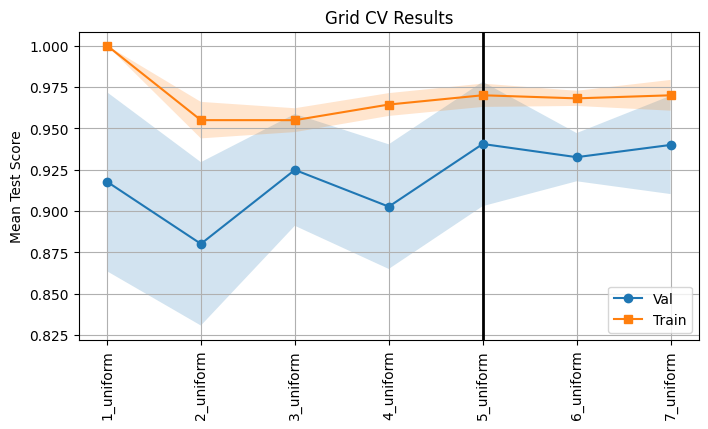

Best parameters: {'clf__n_neighbors': 5, 'clf__weights': 'uniform'}
Best Validation Score:	0.940


In [6]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
KLIST = np.arange(1,8)
WLIST = ['uniform']
params = {'clf__n_neighbors':KLIST, 'clf__weights':WLIST}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

make_grid_plot(grid_clf)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")

# 2) Underfitting

First notice that we only have 133 total samples in X_train.  The grid search then takes 80% for fitting and 20% for validation, so we only have just over 100 samples for training.  Increasing k above that will cause an error.  We wouldn't expect to use k more than n_samples/n_classes ~ 100/3 ~ 33

In [7]:
X_train.shape

(133, 13)

In [8]:
0.8*133

106.4

Above k=60 it starts to seriously underfit.  At the highest values of k we just get random choice based on class weights.

Grid Parameters: {'clf__n_neighbors': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]), 'clf__weights': ['uniform']}


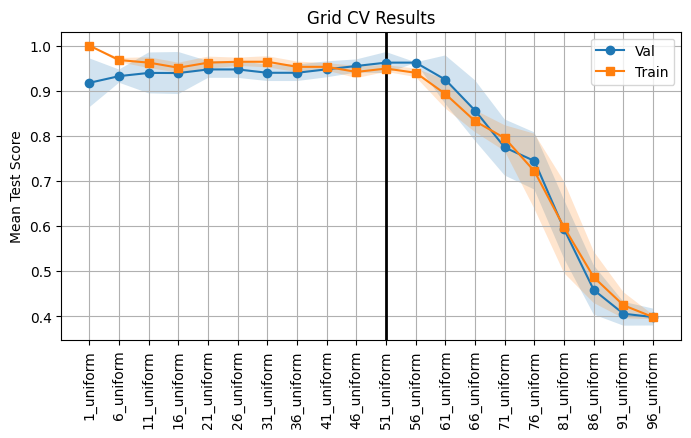

Best parameters: {'clf__n_neighbors': 51, 'clf__weights': 'uniform'}
Best Validation Score:	0.962


In [9]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
KLIST = np.arange(1,101,5)
WLIST = ['uniform']
params = {'clf__n_neighbors':KLIST, 'clf__weights':WLIST}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

make_grid_plot(grid_clf)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")

# 3)  Uniform vs Distance weights
The performance is very similar.  I'll just stick with uniform so I can see the training scores.

Grid Parameters: {'clf__n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37]), 'clf__weights': ['uniform', 'distance']}
Best parameters: {'clf__n_neighbors': 22, 'clf__weights': 'uniform'}
Best Validation Score:	0.962


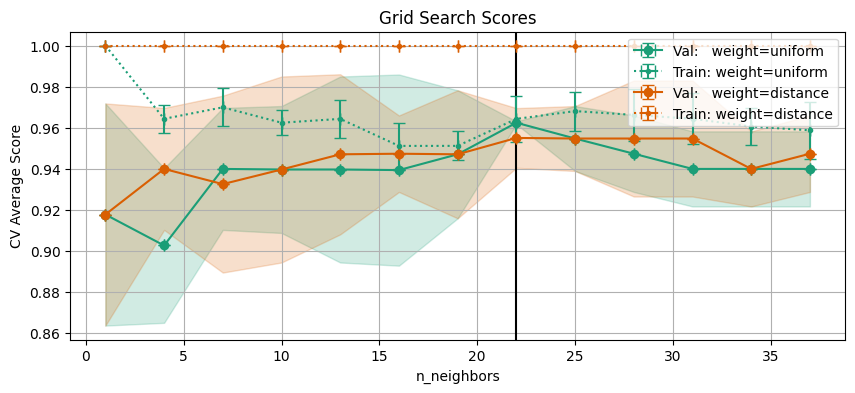

In [10]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
KLIST = np.arange(1,40,3)
WLIST = ['uniform','distance']
params = {'clf__n_neighbors':KLIST, 'clf__weights':WLIST}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

plot_2par_grid_search(grid_clf.cv_results_, KLIST, WLIST, 'n_neighbors', 'weight')  # only works for 2 parameters

print('Best parameters:', grid_clf.best_params_)
print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")

# 4) Optimal Fit

Grid Parameters: {'clf__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39]), 'clf__weights': ['uniform']}


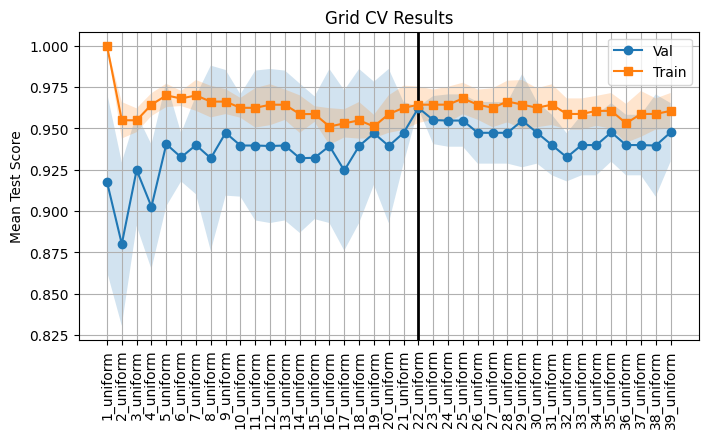

Best parameters: {'clf__n_neighbors': 22, 'clf__weights': 'uniform'}
Best Validation Score:	0.962


In [11]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
KLIST = np.arange(1,40)
WLIST = ['uniform']
params = {'clf__n_neighbors':KLIST, 'clf__weights':WLIST}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

make_grid_plot(grid_clf)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")

# 5) Random State

Grid Parameters: {'clf__n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40]), 'clf__weights': ['uniform']}


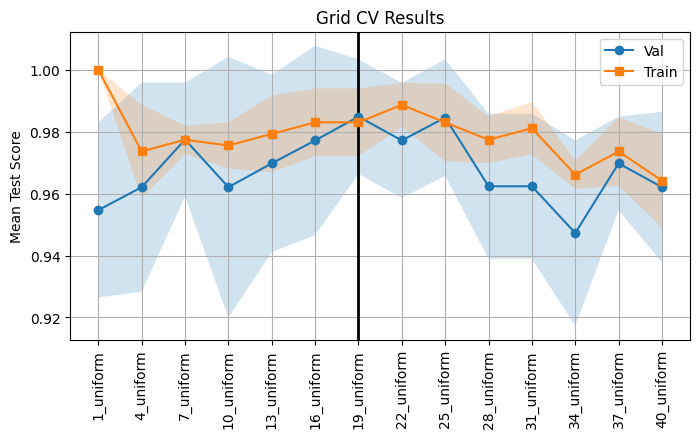

Best parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}
Best Validation Score:	0.985


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y) # stratify ensures an equal ratio of each target
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
KLIST = np.arange(1,42,3)
WLIST = ['uniform']
params = {'clf__n_neighbors':KLIST, 'clf__weights':WLIST}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

make_grid_plot(grid_clf)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")


## The Crusher Of Dreams
The plot in which many illusions are shattered.  

How much does our answer depend on random_state?  A lot!

This is an experimental question.



Grid Parameters: {'clf__n_neighbors': array([ 1,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50]), 'clf__weights': ['uniform']}


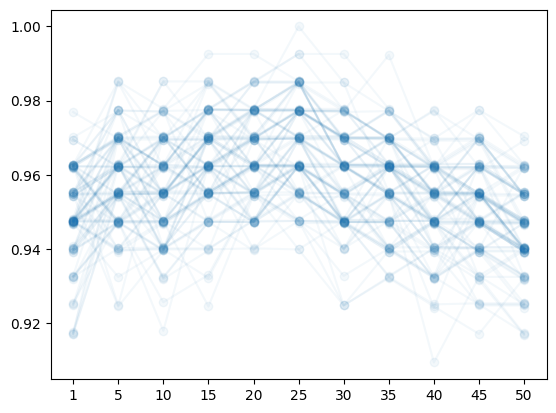

In [28]:
NUM = 100  # takes 90 seconds
#NUM = 50  # takes 45 seconds
#KLIST = np.arange(1,40,5)
KLIST = np.arange(0,51,5)
KLIST[0] = 1
params = {'clf__n_neighbors':KLIST, 'clf__weights':WLIST}
print('Grid Parameters:',params)
grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)

best_counts = np.zeros(len(KLIST)) # save the best fit of each iteration

for i in range(NUM):
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
  grid_clf.fit(X_train, y_train)
  res = grid_clf.cv_results_
  best_counts[grid_clf.best_index_]+=1
  plt.plot(res['mean_test_score'],'-o', label='Val', color='tab:blue', alpha=0.05)
  #plt.plot(res['mean_train_score'],'-o', label='Val', color='tab:orange', alpha=0.05) # makes plot too messy
  plt.xticks(np.arange(len(KLIST)),KLIST)
plt.show()

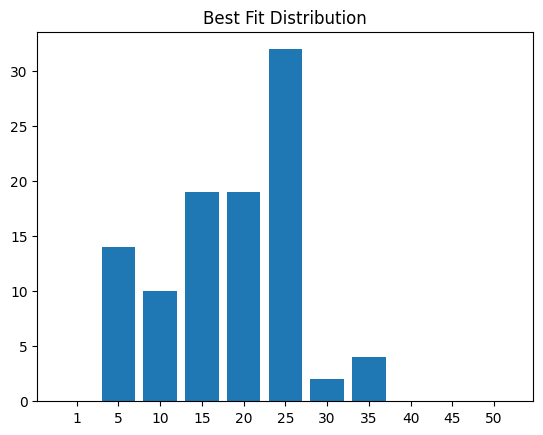

In [38]:
xs = np.arange(len(KLIST))
plt.bar(xs, best_counts)
plt.xticks(np.arange(len(KLIST)),KLIST)
plt.title('Best Fit Distribution')
plt.show()

# Manual Fit
Suppose you wanted to manually specify the parameters.  Here's how to do it

In [39]:
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=25, weights='uniform')) ]
pipe = Pipeline(estimators)
pipe.fit(X_train,y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', KNeighborsClassifier(n_neighbors=25))])

In [40]:
pipe.score(X_test,y_test)

1.0